In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD
import random
random.seed(0)
np.random.seed(0)

In [ ]:
!pip install recommenders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 339 kB 35.9 MB/s 
     |████████████████████████████████| 4.9 MB 55.0 MB/s 
     |████████████████████████████████| 355 kB 55.4 MB/s 
     |████████████████████████████████| 197 kB 63.2 MB/s 
     |████████████████████████████████| 636 kB 59.8 MB/s 
     |████████████████████████████████| 61 kB 8.6 MB/s 
     |████████████████████████████████| 12.4 MB 36.9 MB/s 
     |████████████████████████████████| 310 kB 21.4 MB/s 
     |████████████████████████████████| 11.8 MB 51.1 MB/s 
     |████████████████████████████████| 392 kB 33.2 MB/s 
     |████████████████████████████████| 163 kB 77.5 MB/s 
     |████████████████████████████████| 6.6 MB 58.7 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705379 sha256=94054b68c5f881604af86aa53a4087fa86fc3c37bf0778374f67c8db6acb855b
  Stored in directory: /root/.cache/pip/wh

In [ ]:

from recommenders.models.rbm.rbm import RBM
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.sparse import AffinityMatrix
from recommenders.datasets import movielens
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.timer import Timer
from recommenders.utils.plot import line_graph

## Analyse Dataset

### Book  Dataset
https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset


In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown https://drive.google.com/uc?id=1ccoCOvxD2hFm1ejOVRDlT2SivkoNtC6V

Downloading...
From: https://drive.google.com/uc?id=1ccoCOvxD2hFm1ejOVRDlT2SivkoNtC6V
To: /content/ml-100k.zip
100% 4.92M/4.92M [00:00<00:00, 77.4MB/s]


In [ ]:
!unzip "ml-100k.zip"  -d  "/content"

Archive:  ml-100k.zip
   creating: /content/ml-100k/
  inflating: /content/ml-100k/allbut.pl  
  inflating: /content/ml-100k/mku.sh  
  inflating: /content/ml-100k/README  
  inflating: /content/ml-100k/u.data  
  inflating: /content/ml-100k/u.genre  
  inflating: /content/ml-100k/u.info  
  inflating: /content/ml-100k/u.item  
  inflating: /content/ml-100k/u.occupation  
  inflating: /content/ml-100k/u.user  
  inflating: /content/ml-100k/u1.base  
  inflating: /content/ml-100k/u1.test  
  inflating: /content/ml-100k/u2.base  
  inflating: /content/ml-100k/u2.test  
  inflating: /content/ml-100k/u3.base  
  inflating: /content/ml-100k/u3.test  
  inflating: /content/ml-100k/u4.base  
  inflating: /content/ml-100k/u4.test  
  inflating: /content/ml-100k/u5.base  
  inflating: /content/ml-100k/u5.test  
  inflating: /content/ml-100k/ua.base  
  inflating: /content/ml-100k/ua.test  
  inflating: /content/ml-100k/ub.base  
  inflating: /content/ml-100k/ub.test  


In [ ]:
!mv ml-100k/* ./

In [ ]:
dateparse = lambda x: datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')

rating_df = pd.read_csv('u.data', sep='\t', 
                        names=['userID', 'itemID', 'rating', 'time'], 
                       )

movie_df = pd.read_csv('u.item', sep='|', encoding='latin-1',
                    names=['itemID', 'movie', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'action', 
                           'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 
                           'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western'])

user_df = pd.read_csv('u.user', sep='|', encoding='latin-1',
                     names=['userID', 'age', 'gender', 'occupation', 'zip_code'])


In [ ]:
rating_df=pd.merge(rating_df,movie_df,on="itemID",how="left")


In [ ]:

rating_df["itemID"] = rating_df["itemID"].astype(str)
rating_df["userID"] = rating_df["userID"].astype(str)

In [ ]:
unique_users = rating_df.userID.unique()
user_ids = dict(zip(unique_users, np.arange(unique_users.shape[0], dtype=np.int32)))

unique_items = rating_df.itemID.unique()
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))

In [ ]:
product_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))

### Prepare train test set

In [ ]:
final_ratings=rating_df.sort_values(by=['userID','time'], ascending=[False,False]) 
final_ratings.shape

(100000, 27)

In [ ]:
test_df=final_ratings.groupby('userID').head(30)
test_df.shape

(27051, 27)

In [ ]:
train_df=final_ratings[~final_ratings.isin(test_df).all(1)]
train_df.shape

(100000, 27)

### user/item affiity matrix 

In [ ]:
header = {
        "col_user": "userID",
        "col_item": "itemID",
        "col_rating": "rating",
    }

#instantiate the sparse matrix generation  
am = AffinityMatrix(df = rating_df, **header)

#obtain the sparse matrix 
X, _, _ = am.gen_affinity_matrix()

In [ ]:
Xtr, Xtst = numpy_stratified_split(X)

In [ ]:
#First we initialize the model class
model = RBM(
    possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])),
    visible_units=Xtr.shape[1],
    hidden_units=200,
    training_epoch=200,
    minibatch_size=256,
     display_epoch=10,
    keep_prob=0.1,
    with_metrics=True
)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


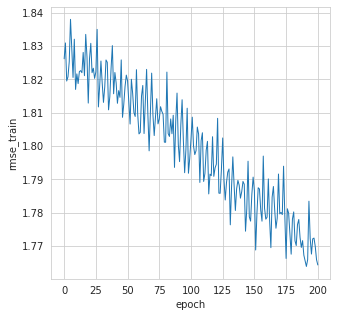

In [ ]:
# Model Fit
model.fit(Xtr)

# Plot the train RMSE as a function of the epochs
line_graph(values=model.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')

In [ ]:
K=20
top_k =  model.recommend_k_items(Xtst,K)


In [ ]:
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')
test_df = am.map_back_sparse(Xtst, kind = 'ratings')



Evaluation

In [ ]:
eval_map = map_at_k(test_df, top_k_df, col_user="userID", col_item="itemID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)
eval_precision = precision_at_k(test_df, top_k_df, col_user="userID", col_item="itemID", 
                               col_rating="rating", col_prediction="prediction", 
                               relevancy_method="top_k", k= K)

eval_recall = recall_at_k(test_df, top_k_df, col_user="userID", col_item="itemID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= K)

In [ ]:
print("MAP : "+str(eval_map))
print("precision : "+str(eval_precision))
print("recall : "+str(eval_recall))

MAP : 0.004355545369551059
precision : 0.029056203605514315
recall : 0.02036052154953004
